

# Gaussian mixture networks for posterior density estimation

This notebook is about approximate Bayesian computation using Gaussian mixtures. Gaussian mixture densities form a dense set in the space of all density functions under L1 metric. 

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.stats import multivariate_normal
from torch.distributions.poisson import Poisson
from torch.distributions.gamma import Gamma
from torch.distributions.uniform import Uniform
import torch.distributions as torch_dist
import itertools as itert
from scipy import stats
import numpy as np
from numbers import Number, Real
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
torch.set_default_tensor_type(torch.DoubleTensor)


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Approximating a 1-d posterior density with a single component Gaussian mixture network

### 1. Problem setup

We consider a statistical model such that 
- the data generating distribution is given by:   $ x \sim p_x(x| \theta)$
- the prior distribution over the parameter space is:   $\theta \sim p_{\theta}(\theta)$
- given iid data $D = \{x_1, x_2, \dots, x_n\}$ from the data process, the posterior distribution is:   $\theta \sim p_{\theta}(\theta | D) \propto p_x(x| \theta) \, p_{\theta}(\theta)$


### 2. GMM approximation

We use a Gaussian mixture approximation to the exact posterior density $$p_{\theta}(\theta | D) \approx q_{\phi}(\theta | D),$$ where $$ q_{\phi}(\theta | D) = \sum_{k=1}^K \alpha_k \, \mathcal{N}\big(\theta | m_k(\phi|D), S_k(\phi|D) \big),$$ and $K$ is the number of Gaussian compenents, $m_k(\phi|D)$ and $S_k(\phi|D)$ are the mean and covariance (variance in 1-d) of the $k^{th}$ component, and the mixing coefficients $\alpha_k$ are such that $\sum_{k=1}^K \alpha_k = 1$ and $\alpha_k \geq 0$.

The parametric family of probability distributions $q_{\phi}(\cdot | D) $ is here parameterized by a neural network. 


### 3. GMM training

#### 3.1.Training data

$$\Big\{\big(\theta_i; D_i =\{x_1^{(i)}, x_2^{(i)}, \dots, x_n^{(i)} \} \big),\: i=1, 2, \dots, N\Big\},$$
where $$\theta_i \sim p_{\theta}(\theta), \quad i=1, 2, \dots, N;$$ and $$x_k^{(i)} \sim p_x(x|\theta=\theta_i), \quad \text{iid}, \quad k=1, 2, \dots, n;$$
and $N$ and $n$ are the number of training examples and the sample size of the data, respectively.

#### 3.2. Mappings

We want to learn the mappings $$D \mapsto m(\phi|D) \quad \text{and} \quad D \mapsto S(\phi|D),$$ such that $q_{\phi}(\theta | D) \approx p_{\theta}(\theta | D)$ as close as possible for any data set $D$.

#### 3.3. Loss function

We parameterize $m(\phi|D)$ and $S(\phi|D)$ a neural network and choose its optimal parameters $\phi$ by maximum likelihood, which, for a single training example $(\theta, D)$, is given by: 

\begin{align*} L(\phi) &= q_{\phi}(\theta | D)  \\ 
&= \Big(2\pi s^2(\phi|D)\Big)^{-1/2} \exp\left(-\frac{\big(\theta - m(\phi|D)\big)^2}{2 s^2(\phi|D)} \right)\end{align*}

The negative log-likelihood for the all $N$ training examples, which is the **loss function**, is therefore given by: $$J(\phi) = \frac{1}{2} \sum_{i=1}^N \left( \frac{\big(\theta_i - m(\phi|D_i)\big)^2}{s^2(\phi|D_i)}  + \log\Big(s^2(\phi|D_i)\Big) \right) + \frac{N}{2} \log(2\pi) $$


#### Loss function

In [150]:
class GMM1DLoss(nn.Module):
    def __init__(self, reg=1.0, weight=None, size_average=True):
        super(GMM1DLoss, self).__init__()
        self.reg = reg              # regularization parameter
        
    def forward(self, inputs, targets):
        '''
            -- this function define the a negative log-likelihood loss function for GMM network optimization
            -- inputs: 2D tensor containing predicted means (1st column) and log variances (2nd column)
                        for each component of the GMM
            -- targets: contains the true values of the model paramater vector θ used for training
            -- λ:      regularization parameter to ensure the GMM approximate posterior is conservative, i.e. σ >> 0
                     we need to explore which type of regularization is better: λ*σ^2 or - 1/(λ*σ^2)
        '''
        # calculate variances
        vars = torch.exp(inputs[:,1])

        # calculate the negative log-likelihood
        J_phi = 0.5 * ((targets.squeeze() - inputs[:,0])**2 / vars  + inputs[:,1] - self.reg / vars ).sum()  #+ 0.5 * inputs.size(0) * np.log(2 * np.pi)
        
        return J_phi


class GMM1DLoss_brute(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(GMM1DLoss, self).__init__()
    
    def forward(self, inputs, targets, λ=0.0):
        '''
            -- this function define the a negative log-likelihood loss function for GMM network optimization
            -- inputs: 2D tensor containing predicted means (1st column) and log standard deviations (2nd column)
                        for each component of the GMM
            -- targets: contains the true values of the model paramater vector θ used for training
            -- λ:      regularization parameter to ensure the GMM approximate posterior is conservative, i.e. σ >> 0
                     we need to explore which type of regularization is better: λ*σ^2 or - 1/(λ*σ^2)
        '''
        # calculate standard deviation
        inputs[:,1] = torch.exp(inputs[:,1])
        
        # initialize the negative log-likelihood
        J_phi = 0
        # iterate over the training examples
        for i in range(inputs.shape[0]):
            # define a Gaussian random variable with mean inputs[i,0] and standard deviation inputs[i,1]
            gaussian = Normal(inputs[i, 0], inputs[i, 1])
            # calculate the log-likelihood and update J_phi
            J_phi -= gaussian.log_prob(targets[i]) - λ * inputs[i, 1]
        
        return J_phi

#### Training data sampling function

In [151]:
def train_gmm(m_μ=0.0, σ_μ=1.0, σ=1.0, sample_size=10,
              N=10**3, batch_size=100):
    '''
        -- To start with, assume the observation model is Gaussian(μ, σ^2)
        -- Assume σ^2 is fixed and known
        -- Assume that the prior for μ is Gaussian with parameters m_μ and σ_μ
        -- We assume that the prior is the proposal to start with
        -- N is the number of training examples
        -- We start with a 1D problem
    '''
    m_μ = torch.tensor([m_μ])
    σ_μ = torch.tensor([σ_μ])
    σ = torch.tensor([σ])
    
    # define the prior
    prior = Normal(m_μ, σ_μ)
    
    # generate N examples of θ = [μ] from the prior
    θ = prior.sample((N,))
    θvec = θ.tile((1, sample_size))
    
    # generate N examples of x_i from the observation model with parameters θ_i, respectively
    X = torch.normal(θvec, σ)
    
    # combine θ & X
    data_train = TensorDataset(X, θ)
    # create a data loader
    data_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    
    return data_loader


def test_gmm(m_μ=0.0, σ_μ=1.0, σ=1.0, sample_size=10,
              N=100):
    '''
        -- To start with, assume the observation model is Gaussian(μ, σ^2)
        -- Assume σ_l is fixed and known
        -- Assume that the prior for μ is Gaussian with parameters m_μ and σ_μ
        -- We assume that the prior is the proposal to start with
        -- N is the number of training examples
        -- We start with a 1D problem
    '''
    m_μ = torch.tensor([m_μ])
    σ_μ = torch.tensor([σ_μ])
    σ = torch.tensor([σ])
    
    # define the prior
    prior = Normal(m_μ, σ_μ)
    
    # generate N examples of θ = [μ] from the prior
    θ = prior.sample((N,))
    θvec = θ.tile((1, sample_size))
    
    # generate N examples of x_i from the observation model with parameters θ_i, respectively
    X = torch.normal(θvec, σ)
    
    
    return (X, θ)



#### $$X \sim Poisson(\theta)$$ and $$\theta \sim Gamma(\alpha, \beta)$$

In [152]:
def train_gmm_poisson(α=5.0, β=1.0, sample_size=10,
              N=10**3, batch_size=100, test=False):
    '''
        -- Assume the observation model is Poisson(θ)
        -- Set the prior for θ ~ Gamma(α, β) on θ
        -- We assume that the prior is the same as the proposal to start with
        -- sample_size: is the size of the sample used to infer θ
        -- N is the number of training examples
    '''

    
    # define the prior
    prior = Gamma(α, β)
    
    # generate N examples of θ from the prior
    θ = prior.sample((N,))
    θvec = θ.tile((sample_size, 1)).T # replicate for simulateous sampling from the data model
    
    # generate N examples of x_i from the observation model with parameters θ_i, respectively
    X = torch.poisson(θvec)
    
    if test:                # if testing data
        return (X, θ)
    # combine θ & X
    data_train = TensorDataset(X, θ)
    # create a data loader
    data_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    
    return data_train

#### function for neural network training


In [153]:
def nn_optimizer(model, data_loader, loss_fn, learning_rate = 0.001,
                 num_epochs=100, echo_after=20, verbose=True, path=None):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_hist = [0] * num_epochs
    
    # optimization loop
    for epoch in range(num_epochs):
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            loss_hist[epoch] += loss.item() * y_batch.size(0)

        loss_hist[epoch] /= len(data_loader.dataset)

        if epoch  % echo_after == 0 and verbose:
            print('Epoch', epoch,  'Loss', loss_hist[epoch], '\n')
        
     # saving the model
    if path:
        torch.save(model, path)
        
    return model

#### Neural network model

In [154]:
class GMM_Model(nn.Module):
    def __init__(self, input_size, sort=False):
        super().__init__()
        self.sort = sort
        self.linear_elu_stack = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ELU(),
            nn.Linear(32, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU()
        )
        self.mean = nn.Linear(16, 1)

        self.logvar = nn.Sequential(
            nn.Linear(16, 8),
            nn.ELU(),
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        if self.sort:
            x = x.sort().values
            
        x = self.linear_elu_stack(x)
        mean = self.mean(x)
        logvar = self.logvar(x)

        return torch.stack((mean, logvar), 1)



# Experiments

#### Experiment 1:
------------------
* Observation model: $$\mathcal{N}(\mu, \sigma^2)$$ where $\sigma^2$ is known

* prior: $$\mu \sim \mathcal{N}(m_\mu, \sigma_\mu^2)$$

In [200]:
# sample training data
n = 10                 # sample size
m_μ=4.0                # prior mean
σ_μ=3.0                # prior standard deviation
σ=2.0                  # standard deviation of the data model

data_loader = train_gmm(m_μ=m_μ, σ_μ=σ_μ, σ=σ, N=20000,
                        sample_size=n, batch_size=30)

## instantiate DNN model
gmm_net = GMM_Model(input_size=n, sort=True).to(device)
loss_fn = GMM1DLoss(reg=0.0)

## train DNN model
gmm_net = nn_optimizer(model=gmm_net, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=0.0001, 
                       num_epochs=201,
                       verbose=True,
                       echo_after=10,
                       path='trained_models/gmm/gaussian_mean_fixed_variance.pt'
                      )



Epoch 0 Loss 111.78125227984732 

Epoch 10 Loss 0.7661762056001427 

Epoch 20 Loss 0.6178798144559576 

Epoch 30 Loss 0.5706575335048815 

Epoch 40 Loss 0.5768516117617791 

Epoch 50 Loss 0.545686301141757 

Epoch 60 Loss 0.5612538147449602 

Epoch 70 Loss 0.5391658936863377 

Epoch 80 Loss 0.5261358984899068 

Epoch 90 Loss 0.5456438462746586 

Epoch 100 Loss 0.5150516854545367 

Epoch 110 Loss 0.5256116384448641 

Epoch 120 Loss 0.509064133260425 

Epoch 130 Loss 0.49785412626247155 

Epoch 140 Loss 0.5220604483006226 

Epoch 150 Loss 0.5037659234591981 

Epoch 160 Loss 0.5001995144466171 

Epoch 170 Loss 0.4891535290272939 

Epoch 180 Loss 0.4876396531449291 

Epoch 190 Loss 0.5004028011875921 

Epoch 200 Loss 0.5042079091430908 



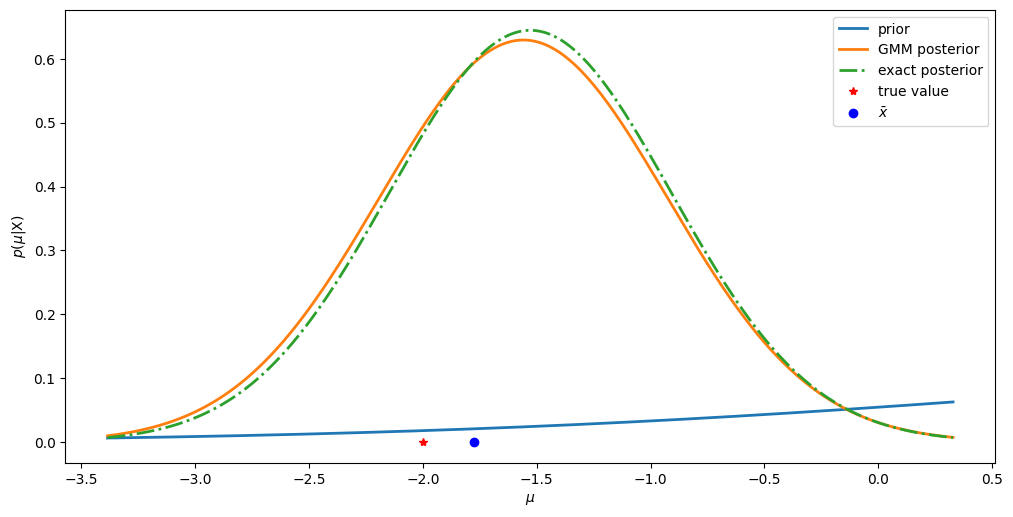

In [242]:
#gmm_net = torch.load('trained_models/gmm/gaussian_mean_only.pt')
### testing on a single example
X, θ = test_gmm(m_μ=m_μ, σ_μ=σ_μ, σ=σ, N=1,
                        sample_size=n)

x0 = X[0, :]
μ0 = θ[0]
with torch.no_grad():
    θpred = gmm_net(x0.to(device)).cpu().squeeze()
    
###################################################
# calculate the mean and variance of the posterior of μ
##################################################
m = σ**2 / σ_μ**2    # ratio data model variance and prior variance
ω = n / (m + n)
μ_post =(1 - ω) * m_μ + ω * x0.mean()          # true posterior mean
σ_post = σ / np.sqrt(m + n)                    # true posterior standard deviation

#################################################
#### define evaluation range for μ  #############

x_μ = torch.linspace(μ_post - 3*σ_post,
                      μ_post + 3*σ_post, 1000)

########################################################
# evaluate the GMM approximate posterior density at x_μ
########################################################
gmm_posterior = Normal(θpred[0], torch.sqrt(torch.exp(θpred[1])))
ypost_gmm = torch.exp(gmm_posterior.log_prob(x_μ))

###############################################
# evaluate the true posterior density at x_μ
###############################################
true_posterior = Normal(μ_post, σ_post)        # initialize the posterior
ypost_true = torch.exp(true_posterior.log_prob(x_μ)) 

#############################################
# evaluate the prior density at x_μ
##############################################
prior = Normal(torch.tensor([m_μ]), torch.tensor([σ_μ]))
yprior = torch.exp(prior.log_prob(x_μ))


#####################################
#  plotting
#####################################
plt.figure(dpi=100, figsize=(12,6))
plt.plot(x_μ, yprior, lw=2, label='prior')
plt.plot(x_μ, ypost_gmm, lw=2, label='GMM posterior')
plt.plot(x_μ, ypost_true, '-.', lw=2, label='exact posterior')
plt.plot(μ0, torch.zeros(1), 'r*',  lw=5, label='true value')
plt.plot(x0.mean(), torch.zeros(1), 'bo',  lw=5, label=r'$\bar{x}$')

plt.legend()
plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu$|X)')
plt.show()

#### Experiment 2:
------------------
* Observation model: $$X|\theta \sim \text{Poisson}(\theta)$$ 

* prior: $$\theta \sim \text{Gamma}(\alpha, \beta)$$

* posterior: $$\theta|x_1, \dots, x_n \sim \text{Gamma}(\alpha^*, \beta^*),$$ where  $$\alpha^* = \alpha + \sum_{i=1}^n x_i \quad \text{and} \quad  \beta^* = \beta + n$$

In [299]:
class GMM_Model_Poisson(nn.Module):
    def __init__(self, input_size, sort=False):
        super().__init__()
        self.sort = sort
        self.linear_elu_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 16),
            nn.ELU(),
            nn.Linear(16, 2)
        )
        self.mean = nn.Linear(16, 1)

        self.logvar = nn.Sequential(
            nn.Linear(16, 16),
            nn.ELU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        if self.sort:
            x = x.sort().values
            
        x = self.linear_elu_stack(x)
        # mean = self.mean(x)
        # logvar = self.logvar(x)

        return x #torch.stack((mean, logvar), 1)


In [305]:
# sample training data
n = 10                   # sample size
α = 5.0                  # prior mean
β = 1.0                  # prior standard deviation
σ = 2.0                  # standard deviation of the data model

data_loader = train_gmm_poisson(α=α, β=β, N=30000,
                        sample_size=n, batch_size=30)

## instantiate DNN model
gmm_net_poisson = GMM_Model_Poisson(input_size=n, sort=True).to(device)
loss_fn = GMM1DLoss(reg=0.0)

## train DNN model
gmm_net_poisson = nn_optimizer(model=gmm_net_poisson, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=0.00001, 
                       num_epochs=201,
                       verbose=True,
                       echo_after=1,
                       path='trained_models/gmm/poisson_sorted.pt'
                      )



Epoch 0 Loss 162.01286435100113 

Epoch 1 Loss 58.11372103835669 

Epoch 2 Loss 48.70324274458621 

Epoch 3 Loss 34.4998451022007 

Epoch 4 Loss 12.156011471798891 

Epoch 5 Loss 4.55092648037583 

Epoch 6 Loss 3.0397816924301404 

Epoch 7 Loss 2.6172371869079254 

Epoch 8 Loss 2.3602375926019707 

Epoch 9 Loss 2.201480565807651 

Epoch 10 Loss 2.106815518860805 

Epoch 11 Loss 2.0466136456365263 

Epoch 12 Loss 2.000888232770874 

Epoch 13 Loss 1.9698406743564085 

Epoch 14 Loss 1.946383929986511 

Epoch 15 Loss 1.9195944571043144 

Epoch 16 Loss 1.8983313352395348 

Epoch 17 Loss 1.885250069935571 

Epoch 18 Loss 1.8734587561390879 

Epoch 19 Loss 1.862306335757623 

Epoch 20 Loss 1.8525920959749713 

Epoch 21 Loss 1.8392826880940558 

Epoch 22 Loss 1.82103104432978 

Epoch 23 Loss 1.8246536035999346 

Epoch 24 Loss 1.8136296546534565 

Epoch 25 Loss 1.796124223774822 

Epoch 26 Loss 1.8013328817853453 

Epoch 27 Loss 1.7945294399788618 

Epoch 28 Loss 1.778415401231166 

Epoch 29 Lo

In [301]:

# class GMM_Model(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.linear_elu_stack = nn.Sequential(
#             nn.Linear(input_size, 16),
#             nn.ELU(),
#             nn.Linear(16, 16),
#             nn.ELU(),
#             nn.Linear(16, 16),
#             nn.ELU(),
#             nn.Linear(16, 2)
#     )
    
#     def forward(self, x):            
#         y = self.linear_elu_stack(x)
        
#         return y

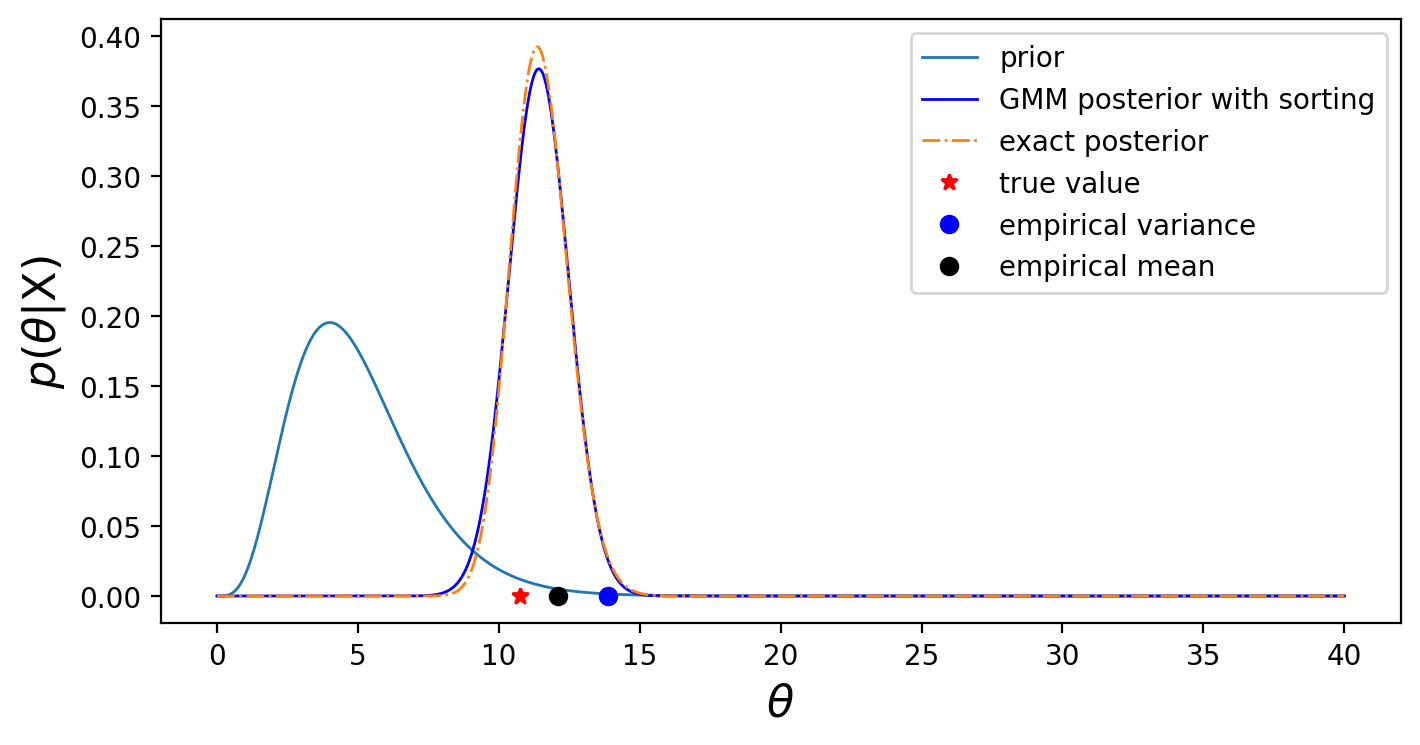

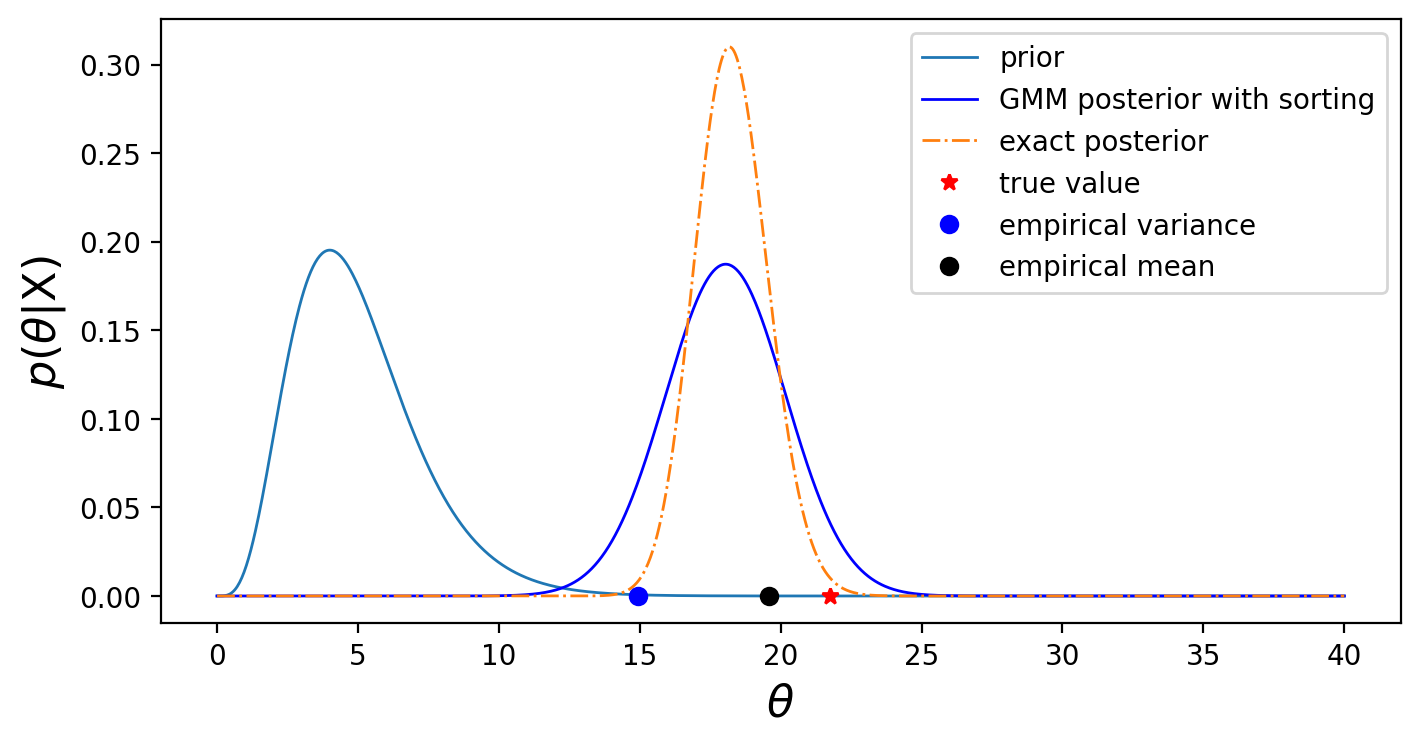

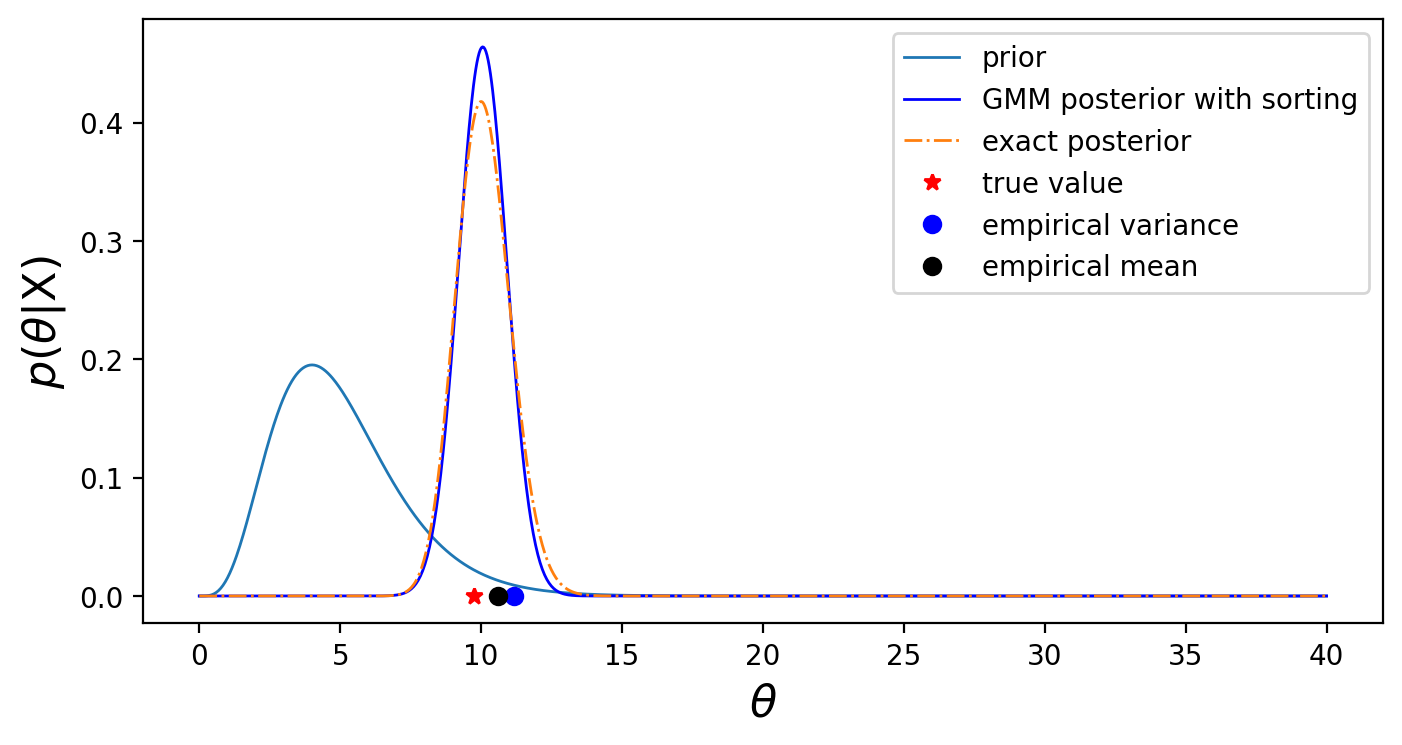

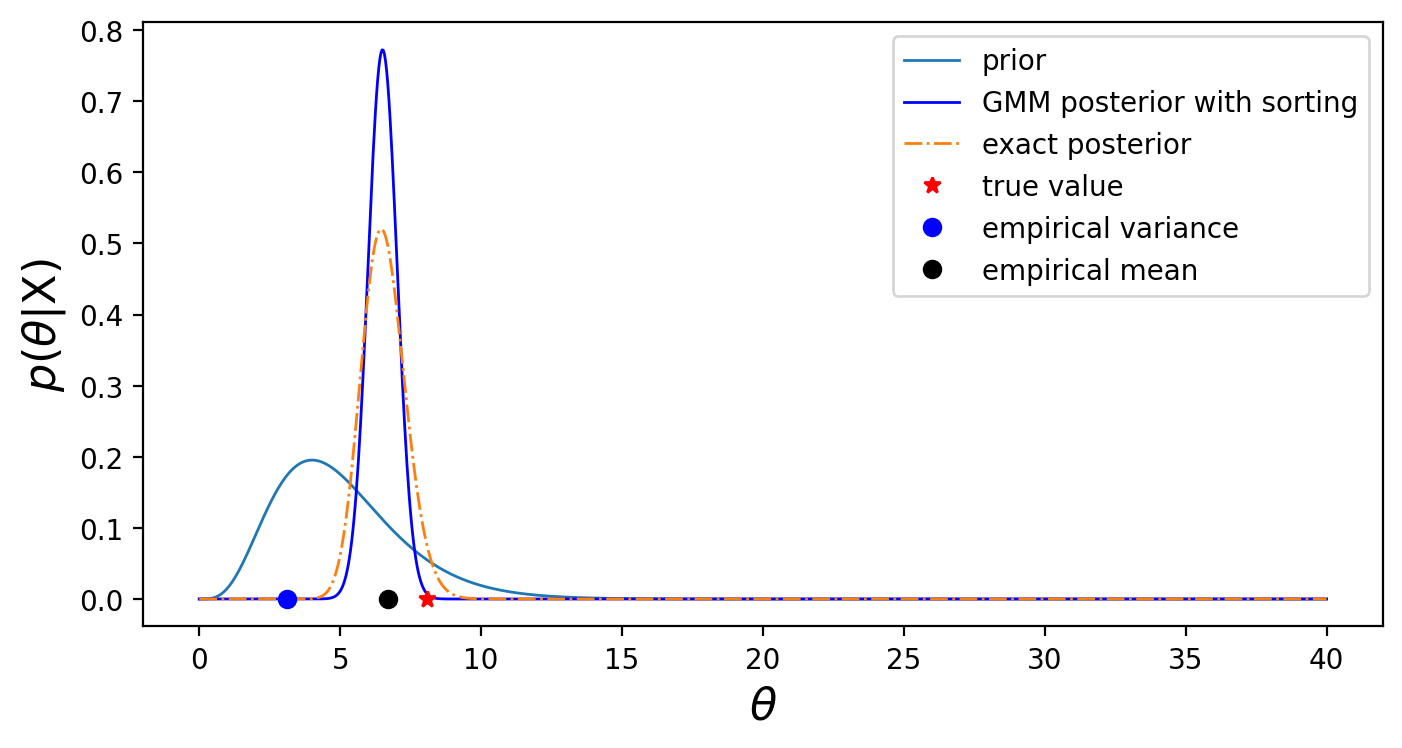

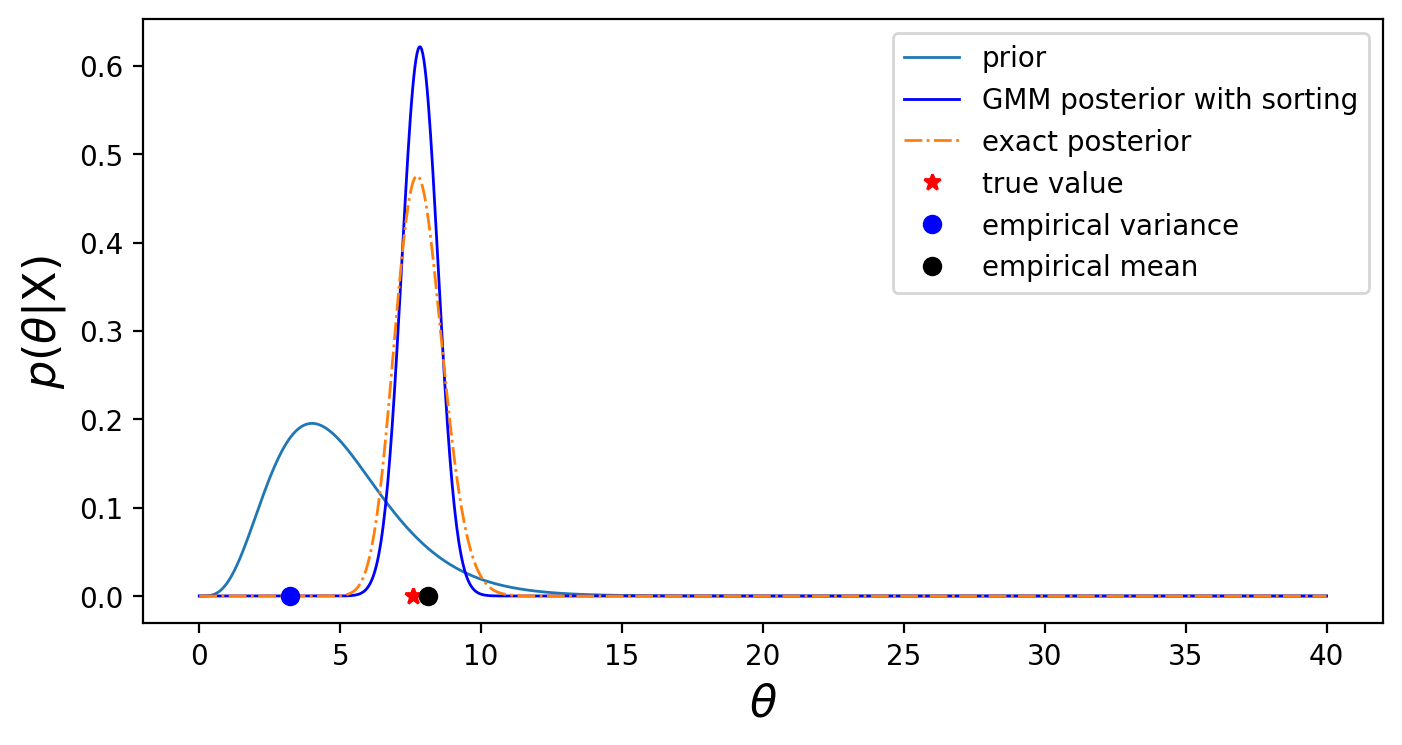

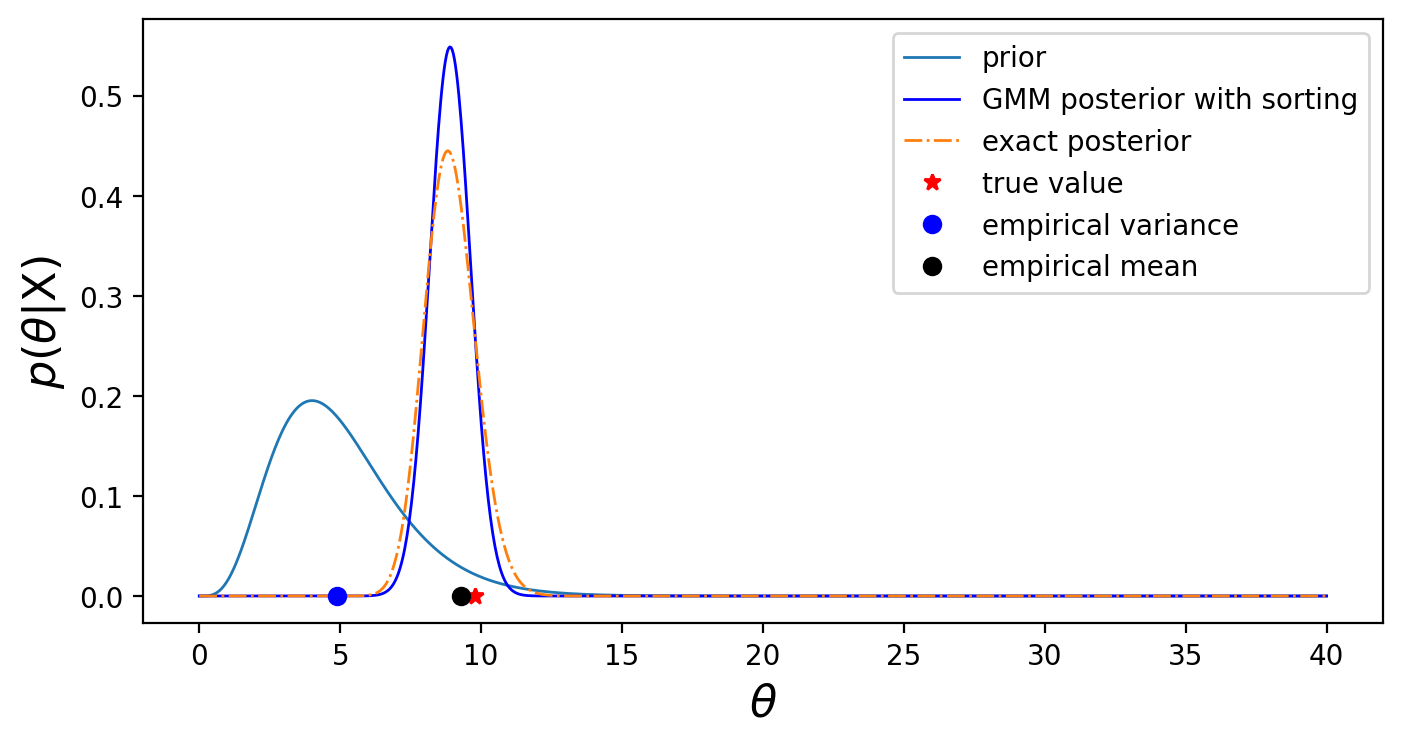

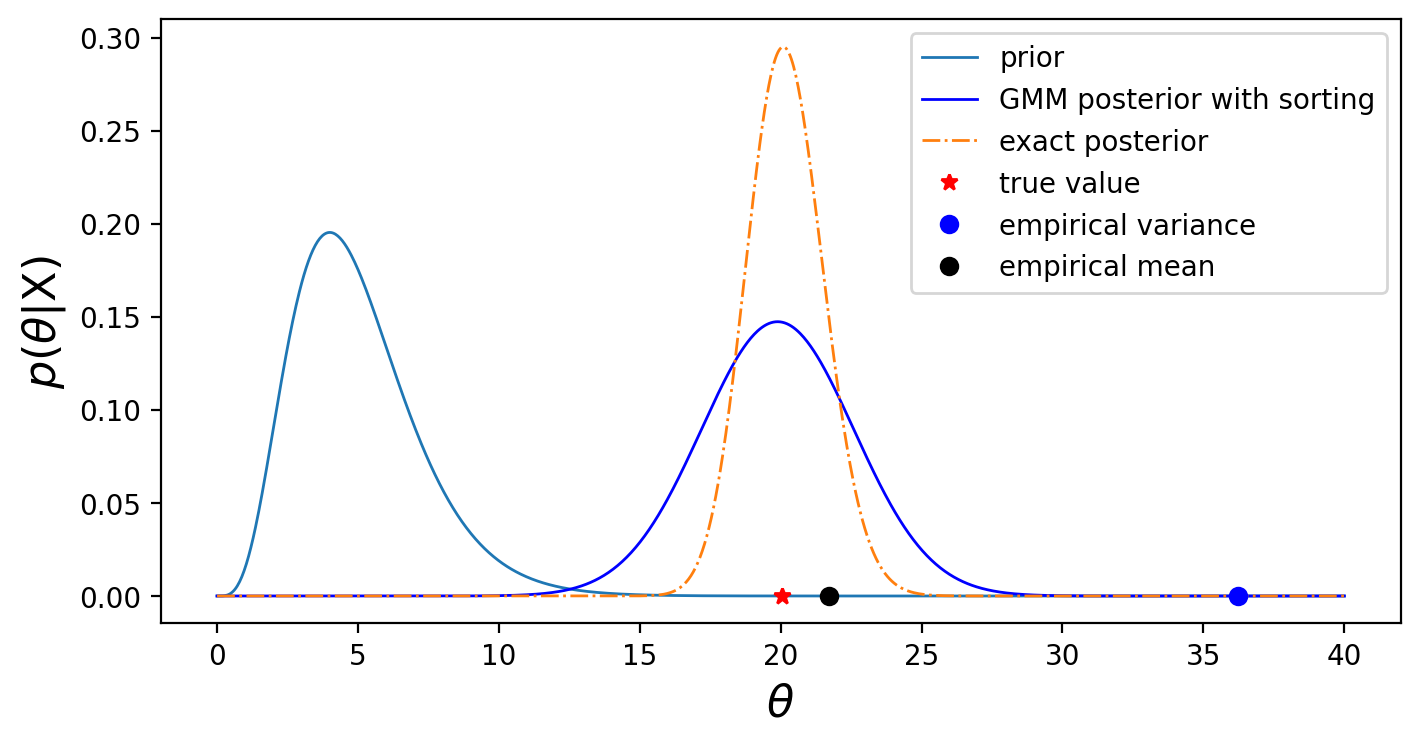

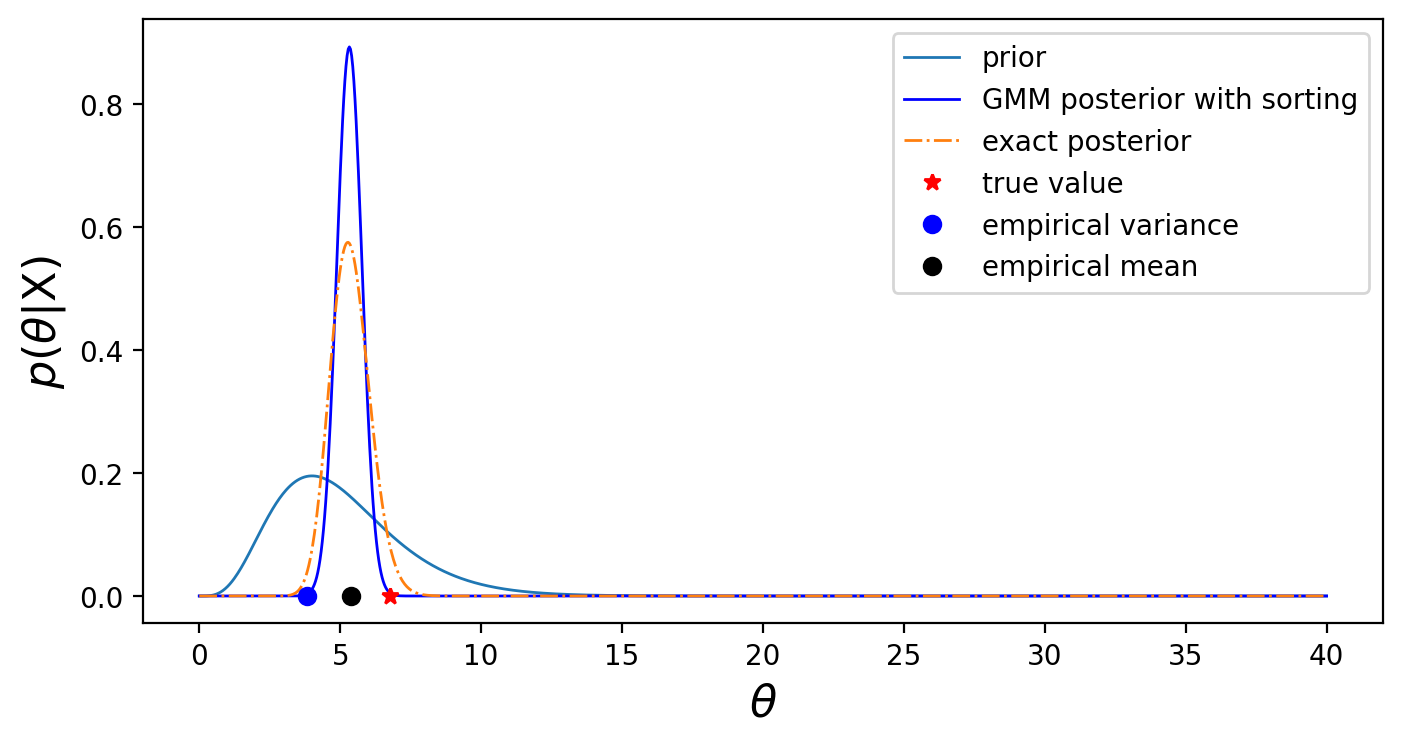

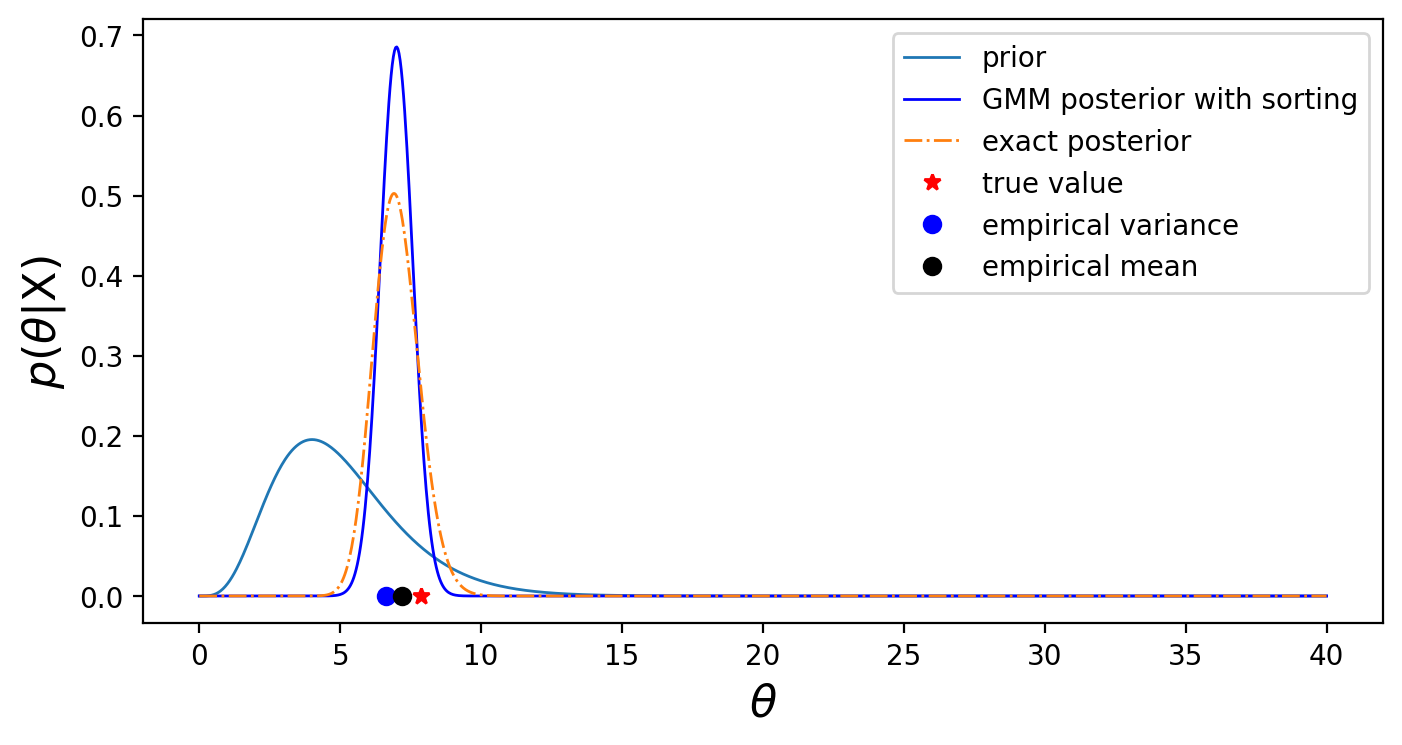

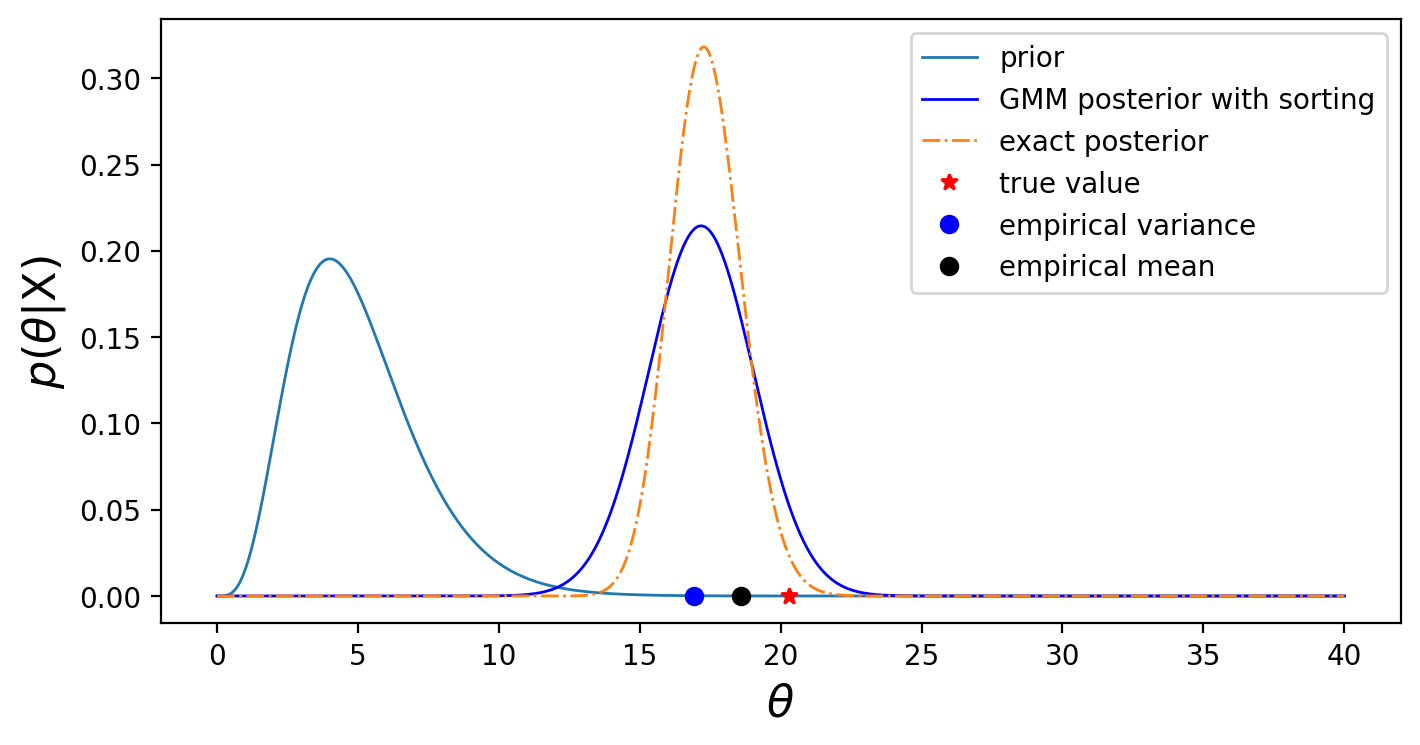

In [302]:
# gmm_net_poisson_0 = GMM_Model(input_size=n).to(device)
# gmm_net_poisson_0 = torch.load('trained_models/gmm/poisson.pt')

### testing on a single example
X, θ = train_gmm_poisson(α=α, β=β/3, N=10,
                        sample_size=n, test=True)
for i in range(len(θ)):
    x0 = X[i, :]
    #x0 = torch.from_numpy(np.random.permutation(x0.numpy()))
    θ0 = θ[i]
    with torch.no_grad():
        θpred = gmm_net_poisson(x0.to(device)).cpu().squeeze()    # with sorting
       # θpred_0 = gmm_net_poisson_0(x0.to(device)).cpu()  # no sorting

    ###################################################
    # calculate the α* and β* of the posterior of θ
    ##################################################
    α_star = α + x0.sum()                            # shape parameter of the true posterior density
    β_star = β + n                                   # rate parameter of the true posterior density

    #################################################
    #### define evaluation range for θ  #############

    x_θ = torch.linspace(0, 8*α, 1000)

    ########################################################
    # evaluate the GMM approximate posterior density at x_μ
    ########################################################
    gmm_posterior = Normal(θpred[0], torch.exp(θpred[1]))
    ypost_gmm = torch.exp(gmm_posterior.log_prob(x_θ))

    # GMM with no sorting
    # gmm_posterior_0 = Normal(θpred_0[0], torch.exp(θpred_0[1]))
    # ypost_gmm_0 = torch.exp(gmm_posterior_0.log_prob(x_θ))
    
    ###############################################
    # evaluate the true posterior density at x_μ
    ###############################################
    true_posterior = Gamma(α_star, β_star)        # initialize the posterior
    ypost_true = torch.exp(true_posterior.log_prob(x_θ)) 

    #############################################
    # evaluate the prior density at x_μ
    ##############################################
    prior = Gamma(α, β)
    yprior = torch.exp(prior.log_prob(x_θ))


    #####################################
    #  plotting
    #####################################
    plt.figure(dpi=200, figsize=(8,4))
    plt.plot(x_θ, yprior, lw=1, label='prior')
    plt.plot(x_θ, ypost_gmm, 'b-', lw=1,  label='GMM posterior with sorting')
   # plt.plot(x_θ, ypost_gmm_0, lw=1, label='GMM posterior')
    plt.plot(x_θ, ypost_true, '-.', lw=1, label='exact posterior')
    plt.plot(θ0, torch.zeros(1), 'r*',  lw=5, label='true value')
    plt.plot(x0.var(), torch.zeros(1), 'bo',  lw=5, label='empirical variance')
    plt.plot(x0.mean(), torch.zeros(1), 'ko', lw=5, label='empirical mean')
    plt.legend(fontsize=10)
    plt.xlabel(r'$\theta$', fontsize=16)
    plt.ylabel(r'$p(\theta$|X)', fontsize=16)
    plt.show()